# Классификация изображений
### Основная идея этого решения: взять предобученую сеть и дообучить под нашу задачу
По отзывам была выбрана есть EfficientB6, дающая высокую точность при приемлимом количестве параметров
B7 на пробном тестировании не показала существенного улучшения, но требовала больше времени на обучение, 
что затрудняло дальнейшие экспиременты.



# Преднастройки

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.io
import tarfile
import csv
import sys
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn

#from ImageDataAugmentor.image_data_augmentor import *
#import albumentations

from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir(os.getcwd() + "/input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

['model_last.hdf5', 'train.csv', 'sample-submission.csv', 'test_upload', 'train']
Python       : 3.8.5 (default, Jul 28 2020, 12:59:40) 
Numpy        : 1.18.5
Tensorflow   : 2.4.0
Keras        : 2.4.0


In [16]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


# Основные настройки

In [3]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Batch size
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
BATCH_SIZE_STEP4     = 2 # Размер batch на шаге с увеличенными изображениями

# Epochs

EPOCHS_STEP1         = 30 
EPOCHS_STEP2         = 30 
EPOCHS_STEP3         = 30
EPOCHS_STEP4         = 30 

# Learning Rates
LR_STEP1             = 1e-3
LR_STEP2             = 1e-4
LR_STEP3             = 1e-5
LR_STEP4             = 1e-5
EPOCHS               = 30  # эпох на обучение
LR                   = 1e-3
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 250 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [4]:
DATA_PATH = os.getcwd() + '/input/'
PATH = os.getcwd() + '/input/' # рабочая директория

In [5]:
# Устаналиваем конкретное значение random seed для воспроизводимости

RANDOM_SEED = 1488
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [6]:
df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [8]:
df.Category.value_counts()
# распределение классов достаточно равномерное - датасет сбалансирован

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

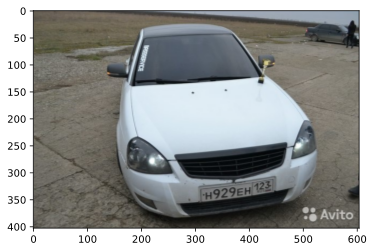

(604, 403)

In [9]:
image = PIL.Image.open(PATH+'/train/0/18293.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size



Как мы видим, классы указывают на модели автомобилей ВАЗ, также присутствуют Ford Focus и Volkswagen Passat


# Подготовка данных

## Аугментация данных

In [10]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)

train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range = 30,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

## Генерация данных

In [11]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


Пример картинок из train_generator


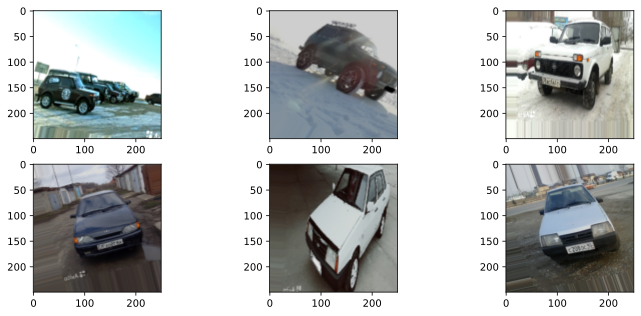

In [26]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


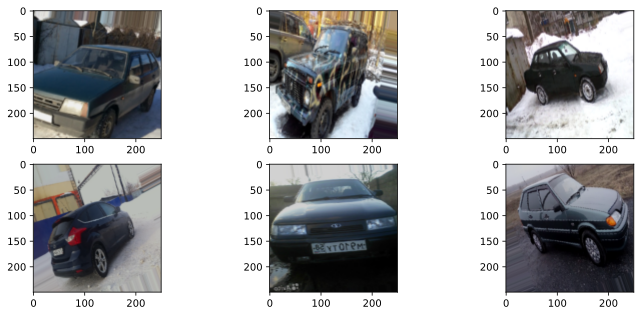

In [27]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Построение модели

За основу берем сеть EfficientB6 в реализации https://github.com/qubvel/efficientnet
Из модуля tf.keras.application с настройками по умолчанию дает точность 11% на первых шагах обучения
против 50% в применяемой реализации.


In [12]:
base_model = efn.EfficientNetB6(
    weights='imagenet',  # возможен вариант noisy-student
    include_top=False,   # голову мы заменяем по причине других классов в исходной сети и главное их количества
    input_shape=input_shape
    )

In [13]:
base_model.summary()

________________
block6h_project_bn (BatchNormal (None, 8, 8, 344)    1376        block6h_project_conv[0][0]       
__________________________________________________________________________________________________
block6h_drop (FixedDropout)     (None, 8, 8, 344)    0           block6h_project_bn[0][0]         
__________________________________________________________________________________________________
block6h_add (Add)               (None, 8, 8, 344)    0           block6h_drop[0][0]               
                                                                 block6g_add[0][0]                
__________________________________________________________________________________________________
block6i_expand_conv (Conv2D)    (None, 8, 8, 2064)   710016      block6h_add[0][0]                
__________________________________________________________________________________________________
block6i_expand_bn (BatchNormali (None, 8, 8, 2064)   8256        block6i_expand_conv[0][0]  

In [30]:
# Заморозим веса imagenet в базовой модели, чтобы она работала в качестве feature extractor 
# и наша голова обучалась делать классификацию на наши 10 классов

base_model.trainable = False

#### Устанавливаем кастомную "голову" в минималистическо классической конфигурации

In [31]:
# Устанавливаем "голову" в минималистическо классической конфигурации
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(256, activation='relu'))
model.add(L.BatchNormalization())
model.add(L.Dropout(0.25))

model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [32]:
# Смотрим на получившуюся модель
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 593,162
Non-trainable params: 40,960,648
______________________________________

In [33]:
# Количество слоев
print(len(model.layers))

6


In [34]:
# Количество параметров обучения
len(model.trainable_variables)

6

In [35]:
# Статус слоев - будем обучать или нет
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f1cc066e100> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f1cc05475b0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f1cd7152cd0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f1cc05fe190> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f1cd690e790> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f1c4423ba00> True


# Обучение модели

## Step 1 - обучение "головы"

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint(MODEL_PATH+'step1-{epoch:02d}-{val_loss:.4f}.hdf5' , monitor = ['val_accuracy'] , verbose = 1, mode = 'max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

In [ ]:
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 76s 195ms/step - loss: 2.3229 - accuracy: 0.0897
Accuracy: 8.97%


In [ ]:
# Обучаем
history = model.fit(
                    train_generator,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=test_generator, 
                    validation_steps=test_generator.samples//test_generator.batch_size,
                    epochs=EPOCHS_STEP1,
                    callbacks = callbacks_list
                    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
1556/1556 [==============================] - ETA: 0s - loss: 1.6750 - accuracy: 0.4138
Epoch 00001: saving model to best_model.hdf5
1556/1556 [==============================] - 373s 240ms/step - loss: 1.6750 - accuracy: 0.4138 - val_loss: 1.1208 - val_accuracy: 0.5925
Epoch 2/20
1556/1556 [==============================] - ETA: 0s - loss: 1.4249 - accuracy: 0.4875
Epoch 00002: saving model to best_model.hdf5
1556/1556 [==============================] - 368s 236ms/step - loss: 1.4249 - accuracy: 0.4875 - val_loss: 1.0515 - val_accuracy: 0.6334
Epoch 3/20
1556/1556 [==============================] - ETA: 0s - loss: 1.3761 - accuracy: 0.5104
Epoch 00003: saving model to best_model.hdf5
1556/1556 [==============================] - 366s 235ms/step - loss: 1.3761 - accuracy: 0.5104 - val_loss: 0.9984 - val_accuracy: 0.6476
Epoch 4/20
1556/1556 [==============================] - ETA: 0s - loss: 1.3191 - acc

удивительно на сколько эта модель хорошо умеет извлекать признаки!

даже без дообучения получаем столь высокий Accuracy



In [ ]:
# Сохраняем обученную модель на первом шаге

model.save('model/model_step1.hdf5')

# Запрашиваем какой файл с весами загрузить как лучший на первом шаге обучения

while not os.path.isfile(weights_name := input('Input name of weights file: ')):
    print("File not exist!")

model.load_weights(weights_name)

## Step 2 - FineTuning

In [ ]:
# Посмотрим на количество слоев в базовой модели
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  659


In [ ]:
# Разморозим базовую модель
base_model.trainable = True

# Установим количество слоев, которые будем переобучать
fine_tune_at = len(base_model.layers)//2

# Заморозим первую половину слоев
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Количество параметров
len(base_model.trainable_variables)

291

In [ ]:
# Статус слоев - будем обучать или нет
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f2b5f55f198> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f2b5ca2a4a8> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f2b5ca2a470> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f2b5c28a748> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f2b5c28ae10> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f2b5c28fd30> True


In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR_STEP2), metrics=["accuracy"])
checkpoint2 = ModelCheckpoint(MODEL_PATH+'step2-{epoch:02d}-{val_loss:.4f}.hdf5' , monitor = ['val_accuracy'] , verbose = 1, mode = 'max')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2304)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               590080    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 41,553,810
Trainable params: 38,289,632
Non-trainable params: 3,264,178
__________________________________

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 76s 196ms/step - loss: 0.7834 - accuracy: 0.7189
Accuracy: 71.89%


In [ ]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 20,
        callbacks = callbacks_list
)

Epoch 1/20
1556/1556 [==============================] - ETA: 0s - loss: 1.0437 - accuracy: 0.6406
Epoch 00001: saving model to best_model.hdf5
1556/1556 [==============================] - 417s 268ms/step - loss: 1.0437 - accuracy: 0.6406 - val_loss: 0.4006 - val_accuracy: 0.8544
Epoch 2/20
1556/1556 [==============================] - ETA: 0s - loss: 0.5812 - accuracy: 0.7944
Epoch 00002: saving model to best_model.hdf5
1556/1556 [==============================] - 413s 266ms/step - loss: 0.5812 - accuracy: 0.7944 - val_loss: 0.2844 - val_accuracy: 0.8956
Epoch 3/20
1556/1556 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.8427
Epoch 00003: saving model to best_model.hdf5
1556/1556 [==============================] - 408s 262ms/step - loss: 0.4583 - accuracy: 0.8427 - val_loss: 0.2218 - val_accuracy: 0.9224
Epoch 4/20
1556/1556 [==============================] - ETA: 0s - loss: 0.3628 - accuracy: 0.8725
Epoch 00004: saving model to best_model.hdf5
1556/1556 [======

In [ ]:
model.save('working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 75s 193ms/step - loss: 0.1759 - accuracy: 0.9498
Accuracy: 94.98%


## Step 3 - FineTuning - разморозка всей сети EfficientNetB6 и дообучение

In [ ]:
# Разморозим базовую модель
base_model.trainable = True

Повторно обучим модель, предварительно разморозив все слои

In [ ]:
LR=0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = 20,
        callbacks = callbacks_list
)

Epoch 1/20
1556/1556 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.9613
Epoch 00001: saving model to best_model.hdf5
1556/1556 [==============================] - 584s 375ms/step - loss: 0.1069 - accuracy: 0.9613 - val_loss: 0.1502 - val_accuracy: 0.9530
Epoch 2/20
1556/1556 [==============================] - ETA: 0s - loss: 0.0854 - accuracy: 0.9717
Epoch 00002: saving model to best_model.hdf5
1556/1556 [==============================] - 581s 373ms/step - loss: 0.0854 - accuracy: 0.9717 - val_loss: 0.1351 - val_accuracy: 0.9581
Epoch 3/20
1556/1556 [==============================] - ETA: 0s - loss: 0.0715 - accuracy: 0.9760
Epoch 00003: saving model to best_model.hdf5
1556/1556 [==============================] - 580s 373ms/step - loss: 0.0715 - accuracy: 0.9760 - val_loss: 0.1285 - val_accuracy: 0.9610
Epoch 4/20
1556/1556 [==============================] - ETA: 0s - loss: 0.0712 - accuracy: 0.9733
Epoch 00004: saving model to best_model.hdf5
1556/1556 [======

In [ ]:
model.save('working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 74s 189ms/step - loss: 0.1459 - accuracy: 0.9598
Accuracy: 95.98%


## Step 4 - увеличение размера изображения

In [ ]:
EPOCHS               = 20
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-5

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range = 30,
    #shear_range=0.2,
    zoom_range=[0.75,1.25],
    #brightness_range=[0.5, 1.5],
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    validation_split=VAL_SPLIT,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


Заново создаем сеть с новым размером входных данных

In [ ]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# Подгружаем ранее обученные веса
model.load_weights('best_model.hdf5')

In [ ]:
# Обучаем
history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_generator.samples//train_generator.batch_size,
        validation_data = test_generator, 
        validation_steps = test_generator.samples//test_generator.batch_size,
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/20
3113/3113 [==============================] - ETA: 0s - loss: 0.3682 - accuracy: 0.8930
Epoch 00001: saving model to best_model.hdf5
3113/3113 [==============================] - 2225s 715ms/step - loss: 0.3682 - accuracy: 0.8930 - val_loss: 0.1166 - val_accuracy: 0.9694
Epoch 2/20
3113/3113 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.9371
Epoch 00002: saving model to best_model.hdf5
3113/3113 [==============================] - 2216s 712ms/step - loss: 0.2110 - accuracy: 0.9371 - val_loss: 0.1076 - val_accuracy: 0.9730
Epoch 3/20
3113/3113 [==============================] - ETA: 0s - loss: 0.1702 - accuracy: 0.9517
Epoch 00003: saving model to best_model.hdf5
3113/3113 [==============================] - 2218s 713ms/step - loss: 0.1702 - accuracy: 0.9517 - val_loss: 0.1070 - val_accuracy: 0.9759
Epoch 4/20
3113/3113 [==============================] - ETA: 0s - loss: 0.1403 - accuracy: 0.9586
Epoch 00004: saving model to best_model.hdf5
3113/3113 [===

In [ ]:
model.save('working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

778/778 [==============================] - 205s 264ms/step - loss: 0.1002 - accuracy: 0.9720
Accuracy: 97.20%


# Предсказание на тестовых данных

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [ ]:
test_sub_generator.samples

6675

In [ ]:
test_sub_generator.reset()
predictions = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

Instructions for updating:
Please use Model.predict, which supports generators.
1669/1669 [==============================] - 188s 113ms/step


In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [ ]:
submission.head()

,Id,Category
0,305108.jpg,7
1,295075.jpg,6
2,31197.jpg,4
3,93598.jpg,9
4,87877.jpg,9


# Test Time Augmentation

https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

Аугментируем тестовые изображения и сделаем несколько предсказаний одной картинки в разном виде. Взяв среднее значение из нескольких предсказаний получим итоговое предсказание.

In [ ]:
model.load_weights('best_model.hdf5')

In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range = 30,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
  )

In [ ]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [ ]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

1669/1669 [==============================] - 497s 298ms/step


In [ ]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Save submit


# Итоги

В ходе выполнения проекта были применены следующие методы:

*    transfer learning и fine-tuning
*    настройка LR, optimizer, loss
*    подобраны переменные (размер картинки, батч и т.д.)
*    SOTA архитектура сетей - EfficientNetB6
*    добавлена Batch Normalization и изменена архитектура “головы”
*    применены дополнительные функции callback Keras https://keras.io/callbacks/
*    TTA (Test Time Augmentation)

Ещё один ноутбук, в котором использовалась библиотека аугментации Albumenations и Learning rate One Cycle Policy: https://www.kaggle.com/fedorazarov/car-classification-fa